# Hybrid attack

### Load results 

In [94]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from itertools import product

# parameters 
dataset_names = ['cora', 'polblogs']
graph1_props = [0.0]
common_props = [0]
sns.set(font_scale=1.2)
sns.set_theme(style="whitegrid")

graph_statistics = {
    "acm" : {
        "nodes": 3025,
        "edges": 13128,
    },
    "polblogs" : {
        "nodes": 1222,
        "edges": 16714,
    },
    "flickr" : {
        "nodes": 7575,
        "edges": 239738,
    },
    "cora" : {
        "nodes": 2485,
        "edges": 5069,
    },
    "block" : {
        "nodes": 3346,
        "edges": 54901,
    },

    "bio-diseasome" : {
        "nodes": 516,
        "edges": 1188,
    },
    "netscience" : {
        "nodes": 379,
        "edges": 914,
    },
    
}

results = {}

erdos_results = {
    "polblogs": (16713, 0, 730537, 1),
    "cora": (5053, 17, 3083767, 16),
    "flickr": (2166, 230418, 28446934, 14548),
    "acm": (12970, 22, 4563645, 158),
    "block": (10756, 36678, 2760575, 43935),
    "bio-diseasome": (1182, 10, 132188, 6),

}

## Accuracy (number of slots correctly filled in the adjacency matrix)

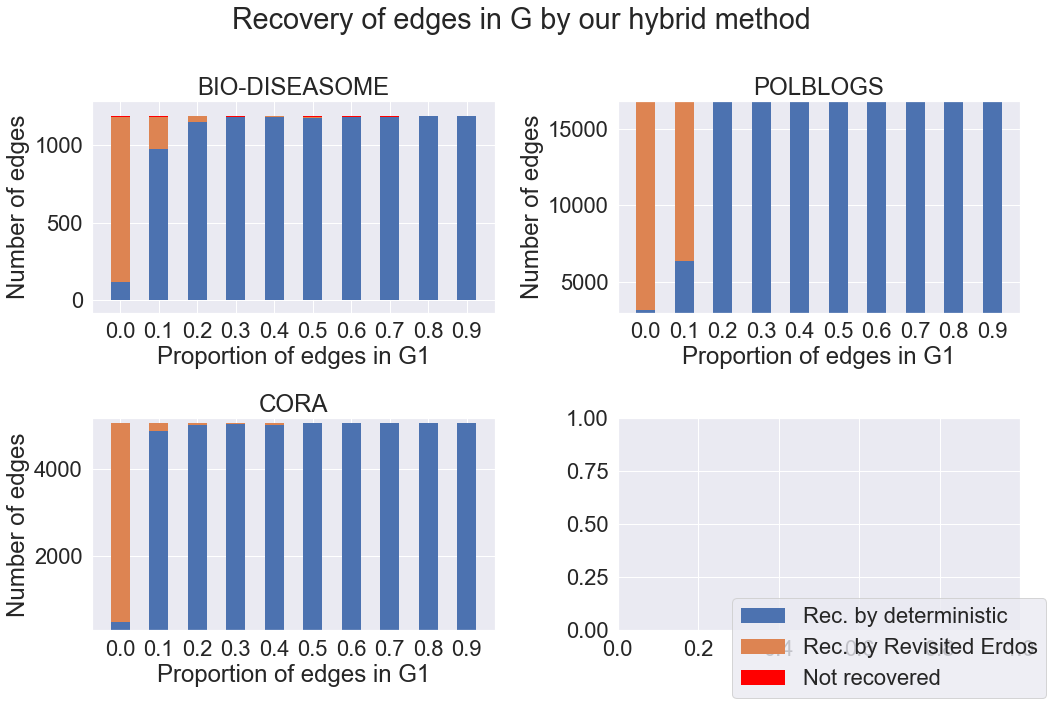

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid")
sns.set(font_scale=2)  # crazy big

dataset_names = ['bio-diseasome', 'polblogs', 'cora']
fig, axes = plt.subplots(2 , 2, figsize=(15, 10))
graph1_props = [0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for i, dataset_name in enumerate(dataset_names):
    data = pd.read_csv(f"logs_erdos/{dataset_name}.csv", header=None)
    data.columns = ['run', 'attack_type','graph1_prop', 'common_prop', 'iter_num', 'absent', 'present', 'unknown', 'TP', 'FP', 'TN', 'FN', 'time']

    results =  []

    for prop in graph1_props:
        last_deterministic = data[(data['graph1_prop'] == prop) & (data['common_prop'] == 0) & (data['attack_type'] == 'deterministic')].tail(1)
        erdos = data[(data['graph1_prop'] == prop) & (data['common_prop'] == 0) & (data['attack_type'] == 'erdos')]

        if len(erdos) == 0:
            results.append((last_deterministic["TP"].values[0], 0, 0))
        else:
            erdos = erdos.tail(1)
            deterministic = last_deterministic["TP"].values[0]
            r_erdos = erdos["TP"].values[0] - last_deterministic["TP"].values[0]
            missing = graph_statistics[dataset_name]["edges"] - erdos["TP"].values[0]
            results.append((deterministic, r_erdos, missing))

    results = np.array(results)

    bar_width = 0.05
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    ax.bar(graph1_props, results[:, 0], width=bar_width, label='Rec. by deterministic' if i == 0 else "", edgecolor='none')
    ax.bar(graph1_props, results[:, 1], width=bar_width, bottom=results[:, 0], label='Rec. by Revisited Erdos' if i == 0 else "", edgecolor='none')
    ax.bar(graph1_props, results[:, 2], width=bar_width, bottom=results[:, 0] + results[:, 1], label='Not recovered' if i == 0 else "", edgecolor='none', color='red')

    ax.set_ylim(min(results[:, 0]) - 200, graph_statistics[dataset_name]["edges"] + 100)
    ax.set_title(f'{dataset_name.upper()}')
    ax.set_xlabel('Proportion of edges in G1')
    ax.set_ylabel('Number of edges')
    ax.set_xticks(graph1_props)  # Set the x-axis ticks to match the positions
    

plt.suptitle('Recovery of edges in G by our hybrid method')
plt.tight_layout()
fig.legend(loc="lower right")
fig.subplots_adjust(top=0.85)
plt.show()





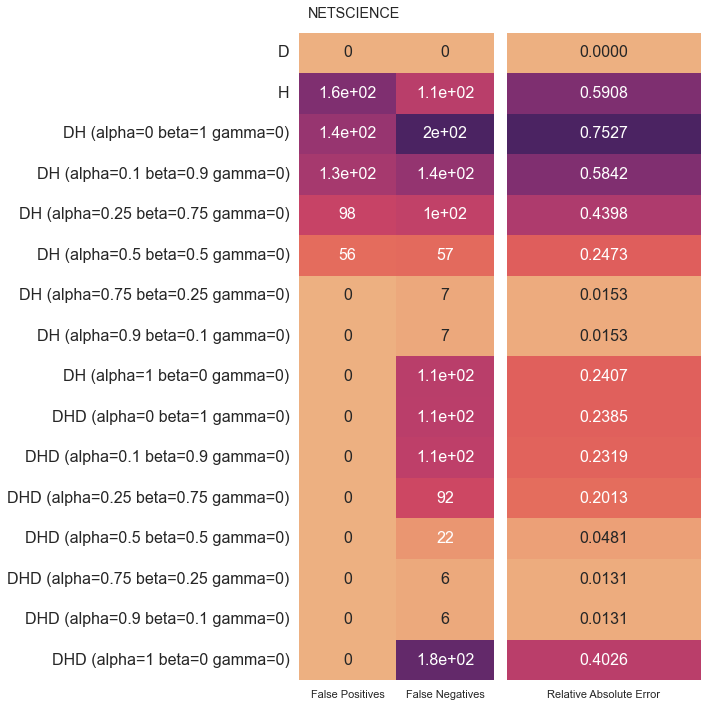

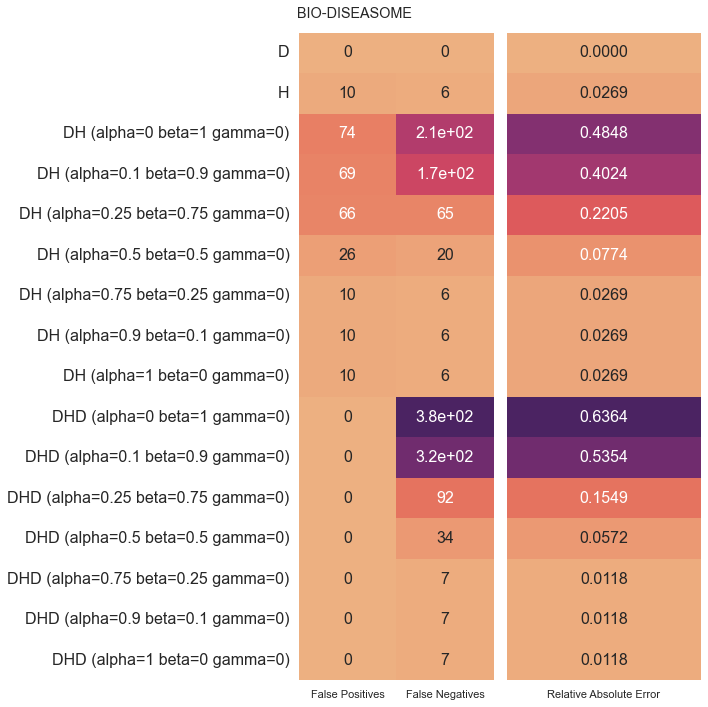

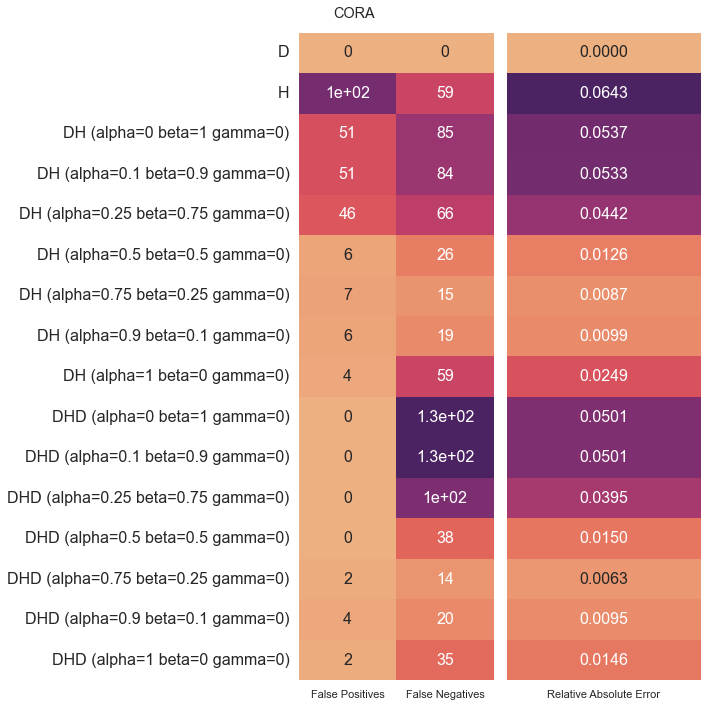

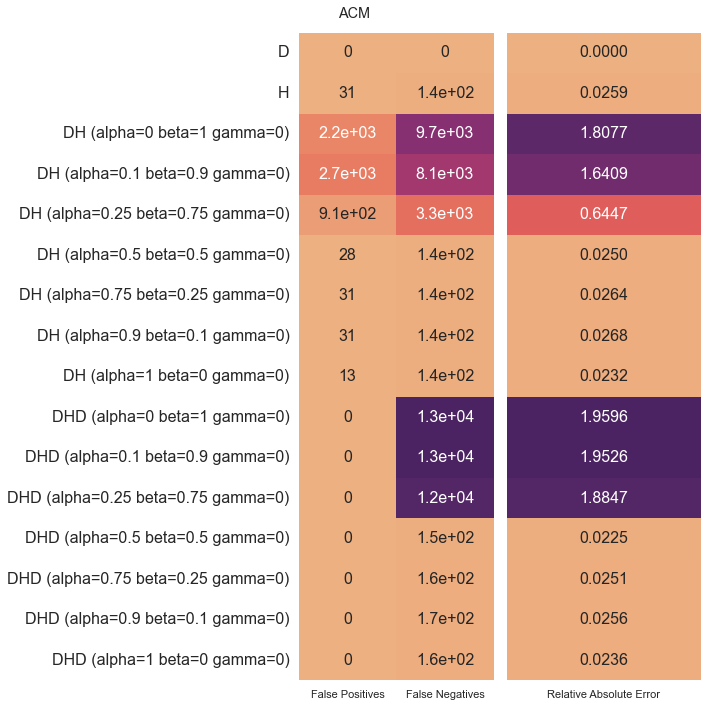

In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid") 
columns = ["D",
            "H",
            "DH (alpha=0 beta=1 gamma=0)",
            "DH (alpha=0.1 beta=0.9 gamma=0)",
            "DH (alpha=0.25 beta=0.75 gamma=0)",
            "DH (alpha=0.5 beta=0.5 gamma=0)",
            "DH (alpha=0.75 beta=0.25 gamma=0)",
            "DH (alpha=0.9 beta=0.1 gamma=0)",
            "DH (alpha=1 beta=0 gamma=0)",
            "DHD (alpha=0 beta=1 gamma=0)",
            "DHD (alpha=0.1 beta=0.9 gamma=0)",
            "DHD (alpha=0.25 beta=0.75 gamma=0)",
            "DHD (alpha=0.5 beta=0.5 gamma=0)",
            "DHD (alpha=0.75 beta=0.25 gamma=0)",
            "DHD (alpha=0.9 beta=0.1 gamma=0)",
            "DHD (alpha=1 beta=0 gamma=0)",
            ]

datasets = ['netscience', 'bio-diseasome', 'cora', 'acm']
RAE_plus = []
RAE_minus = []
for i, result in enumerate(datasets):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10), sharey=True)
    data = pd.read_csv(f"logs/{result}.csv")
    data.columns = ["expe","attack_type","alpha","beta","gamma","graph1_prop","common_prop","iter_number","impossible_edges","reconstructed_edges","unknown_edges","TP","FP","TN","FN","time"]
    data["attack"] = data["attack_type"] + " " + data["alpha"].astype(str) + " " + data["beta"].astype(str) + " " + data["gamma"].astype(str)
    values = data[["FP","FN"]]

    RAE_plus = 2 * (values["FP"] + values["FN"]) / data["TP"]

    RAE = 2 * (values["FP"] + values["FN"]) / graph_statistics[result]["edges"]
    sns.heatmap(values.to_numpy(), ax=ax1, cbar=False, yticklabels=True, annot=True, cmap="flare", annot_kws={"size": 16})
    ax1.set_yticklabels(columns, rotation=0, fontsize=16)
    ax1.set_xticklabels(["False Positives", "False Negatives"])

    sns.heatmap(RAE.to_numpy().reshape(-1, 1), ax=ax2, cbar=False, annot=True, fmt=".4f", cmap="flare", annot_kws={"size": 16})
    ax2.set_yticklabels(columns, rotation=0, fontsize=15)
    ax2.set_xticklabels(["Relative Absolute Error"])
    fig.suptitle(result.upper())
    fig.tight_layout()





